****This data was extracted from the 1994 Census bureau database by Ronny Kohavi and Barry Becker (Data Mining and Visualization, Silicon Graphics). The prediction task is to determine whether a person makes over $50K a year.****

# Import libraries


In [ ]:
#install extra Machine Learning Libraries
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

!pip install -q rasterio rasterstats geopandas lightgbm

     |████████████████████████████████| 67.3MB 43kB/s 
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
     |████████████████████████████████| 19.1MB 158kB/s 
     |████████████████████████████████| 1.0MB 20.1MB/s 
     |████████████████████████████████| 92kB 10.8MB/s 
     |████████████████████████████████| 15.3MB 208kB/s 
     |████████████████████████████████| 133kB 57.9MB/s 
     |████████████████████████████████| 6.5MB 49.3MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

#for imbalanced data
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

#Machine learning libraries
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV, ShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report,plot_roc_curve
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Acquire Data

In [ ]:
train_df = pd.read_csv('https://raw.githubusercontent.com/KeynWeight/Adult-census-income/main/adult_train.csv')
test_df = pd.read_csv('https://raw.githubusercontent.com/KeynWeight/Adult-census-income/main/adult_test.csv')

In [ ]:
train_df.sample(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,wage
3212,49,Private,199029,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,0,2415,55,United-States,>50K
5731,47,Self-emp-not-inc,118506,Bachelors,13,Married-civ-spouse,Exec-managerial,Own-child,White,Male,0,0,60,United-States,<=50K
19505,23,Private,119665,HS-grad,9,Never-married,Adm-clerical,Not-in-family,White,Male,0,0,60,United-States,<=50K
20998,38,Local-gov,167440,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,20,United-States,<=50K
3180,30,Local-gov,326104,HS-grad,9,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
9373,40,Private,224799,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,45,United-States,<=50K
29027,30,Private,56004,Some-college,10,Never-married,Exec-managerial,Own-child,Black,Female,0,0,40,United-States,<=50K
9994,34,Self-emp-not-inc,175697,Assoc-voc,11,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,75,United-States,<=50K
1043,44,Private,167005,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,7688,0,60,United-States,>50K
28145,56,?,35723,HS-grad,9,Divorced,?,Own-child,White,Male,0,0,40,United-States,<=50K


# Initial Analysis on the data

In [ ]:
# Check data types and null values in each column

train_df.info()
print('_'*80)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  wage            32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
________________________________________________________________________________
<class 'pand

In [ ]:
# Check distribution in numerical columns

train_df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [ ]:
# Check unique values in each column and check any input error in the entry

for column in train_df.columns:
  print('Column: ' + column)
  print(train_df[column].value_counts())
  print('-'*30)
  print('unique train_df values: ' + str(np.sort(train_df[column].unique())))
  print('unique test_df values: ' + str(np.sort(test_df[column].unique())))
  print('-'*100)

Column: age
36    898
31    888
34    886
23    877
35    876
     ... 
83      6
85      3
88      3
87      1
86      1
Name: age, Length: 73, dtype: int64
------------------------------
unique train_df values: [17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64
 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88
 90]
unique test_df values: [17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64
 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 87 88 89
 90]
----------------------------------------------------------------------------------------------------
Column: workclass
 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without

In [ ]:
## Find duplicated rowd
DuplicatedRow = train_df[train_df.duplicated()]
DuplicatedRow

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,wage
4881,25,Private,308144,Bachelors,13,Never-married,Craft-repair,Not-in-family,White,Male,0,0,40,Mexico,<=50K
5104,90,Private,52386,Some-college,10,Never-married,Other-service,Not-in-family,Asian-Pac-Islander,Male,0,0,35,United-States,<=50K
9171,21,Private,250051,Some-college,10,Never-married,Prof-specialty,Own-child,White,Female,0,0,10,United-States,<=50K
11631,20,Private,107658,Some-college,10,Never-married,Tech-support,Not-in-family,White,Female,0,0,10,United-States,<=50K
13084,25,Private,195994,1st-4th,2,Never-married,Priv-house-serv,Not-in-family,White,Female,0,0,40,Guatemala,<=50K
15059,21,Private,243368,Preschool,1,Never-married,Farming-fishing,Not-in-family,White,Male,0,0,50,Mexico,<=50K
17040,46,Private,173243,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
18555,30,Private,144593,HS-grad,9,Never-married,Other-service,Not-in-family,Black,Male,0,0,40,?,<=50K
18698,19,Private,97261,HS-grad,9,Never-married,Farming-fishing,Not-in-family,White,Male,0,0,40,United-States,<=50K
21318,19,Private,138153,Some-college,10,Never-married,Adm-clerical,Own-child,White,Female,0,0,10,United-States,<=50K


Findings from initial examination of the data:

1. `workclass`, `occupation` and `native-country` columns have significant number of "?" value, which should be treated as null values. We will have to clean this in our train and test dataset as well.
2. The 25th-75th quantile of `capital-gain` and `capital-loss` are 0, which means the data is highly skewed. We may need scaling.
3. There is no description of `fnlwgt` variable in the dataset description and there is no insight from the data. We will drop this variable in our further analysis.
4. There is whitespace in the entries, we'll have to strip it.
5. No duplicated row
6. There are different formats of inputs in train dataset and test dataset, which are needed to be cleaned

# Data Cleaning

1. We will strip whitespace in the data of both training and testing dataset first

In [ ]:
# Drop fnlwgt in both datasets

train_df = train_df.drop('fnlwgt',axis=1)
test_df = test_df.drop('fnlwgt',axis=1)

# Get numeric columns and categorical number to a list
n_col = train_df.select_dtypes(include=np.number).columns.tolist()
c_col = train_df.select_dtypes(include=['object']).columns.tolist()

#Check what columns we selected
print('Numeric columns: ' + str(n_col))
print('Categorical columns: ' + str(c_col))

#strip whitespace
train_df = train_df.astype(str).applymap(lambda x: x.strip())
test_df = test_df.astype(str).applymap(lambda x: x.strip())


for col1 in n_col:
    train_df[col1] = train_df[col1].astype('int64')
    test_df[col1] = test_df[col1].astype('int64')
    


Numeric columns: ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical columns: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'wage']


In [ ]:
# Change format of values in `wage` column

test_df['wage'] = test_df['wage'].str.replace('.','')

In [ ]:
#replace ? to NaN

train_df[train_df == '?'] = np.nan
test_df[test_df == '?'] = np.nan

#Check null values
print('Training')
print(train_df.isnull().sum())
print('Row count with null value: ' + str(len(train_df[train_df.isnull().any(axis=1)])))
print('-'*40)
print('Testing')
print(test_df.isnull().sum())
print('Row count with null value: '+ str(len(test_df[test_df.isnull().any(axis=1)])))

Training
age                  0
workclass         1836
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
wage                 0
dtype: int64
Row count with null value: 2399
----------------------------------------
Testing
age                 0
workclass         963
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
wage                0
dtype: int64
Row count with null value: 1221


Since the number of rows containing null values in training set is just 2399, which is just 7% of the data, same for test set. We will just drop it for convenience.

In [ ]:
# Drop rows with NA values
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [ ]:
#Check any unseen data in test df
a = train_df['native-country'].unique()
b = test_df['native-country'].unique()
list(set(b)- set(a))

[]

Here i create a function to group the countries based on the economy and district for easier analysis

In [ ]:
def convert_countries(x):
  country_dict = {
  '1': 'United-States',
  '2': ['England', 'Canada', 'Germany', 'France','Scotland','Ireland'],
  '3': ['Taiwan', 'Japan','China'],
  '4': ['Poland','Italy' , 'Hungary','Greece','Portugal','Yugoslavia'],
  '5': ['Cuba', 'Jamaica','Mexico','Puerto-Rico', 'Honduras','Columbia','Ecuador','Trinadad&Tobago','Nicaragua', 'Haiti','Dominican-Republic', 'El-Salvador','Guatemala','Peru'],
  '6': ['India', 'Iran', 'Philippines','Cambodia', 'Thailand','Laos','Vietnam'],
  '7': ['South','Hong','Holand-Netherlands','Outlying-US(Guam-USVI-etc)']
  }
  return next((int(k) for k, v in country_dict.items() if x in v), None)


train_df['native-country'] = train_df['native-country'].apply(convert_countries)
test_df['native-country'] = test_df['native-country'].apply(convert_countries)

# Simple Data visualization
After data cleaning, we'll do some simple visualization of our data to view the distribution and relationship of variables.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd520294810>,
      dtype=object)

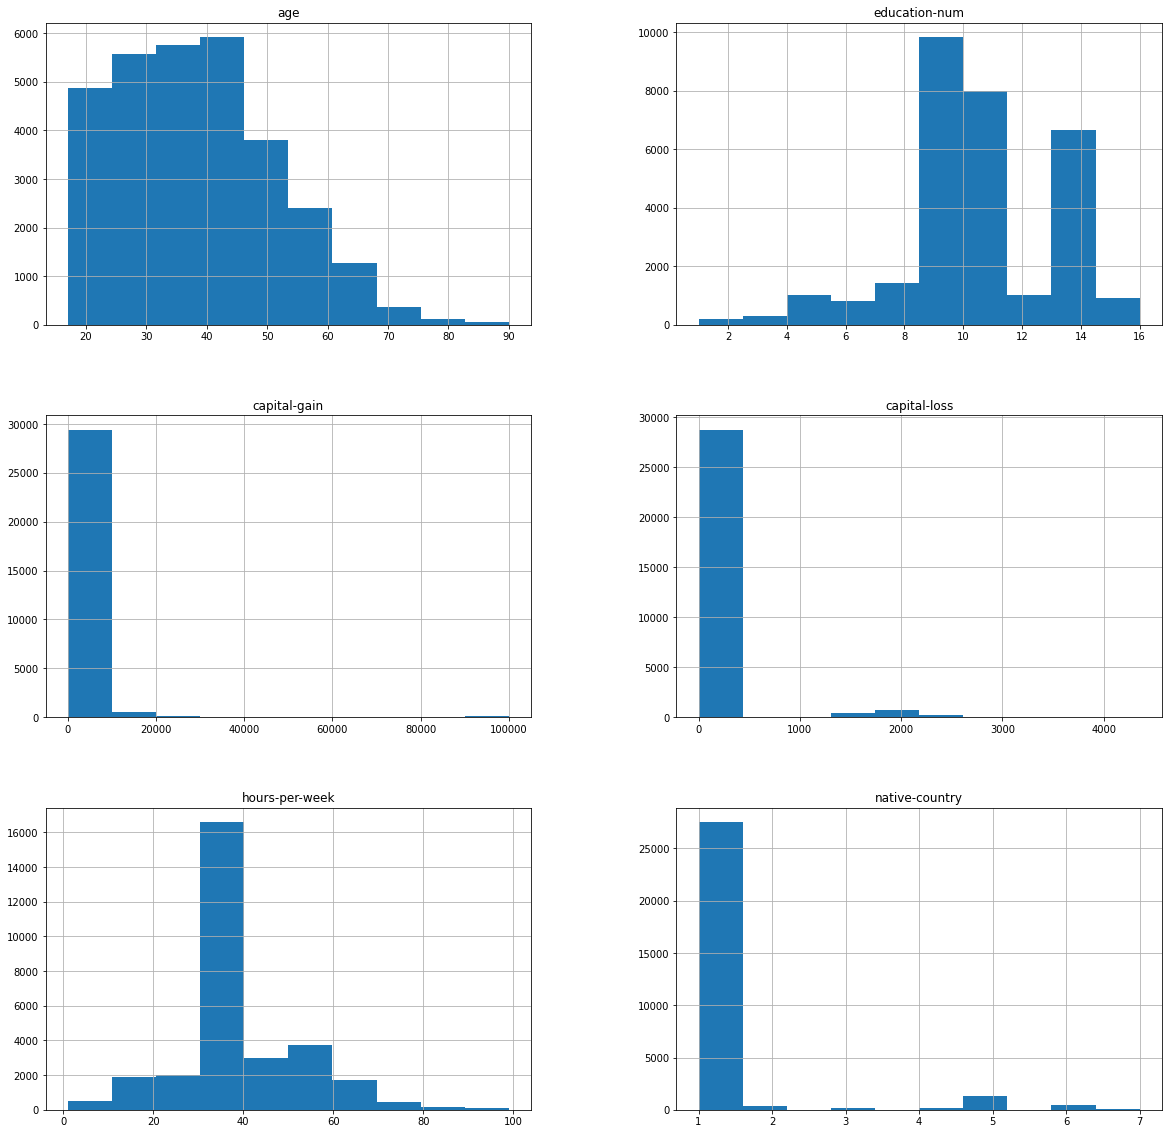

In [ ]:
# Check the distribution of the data

train_df.hist(figsize=(20,20))

We can see capital gain and capital loss variables are highly skewed, which are needed to be scaled before training

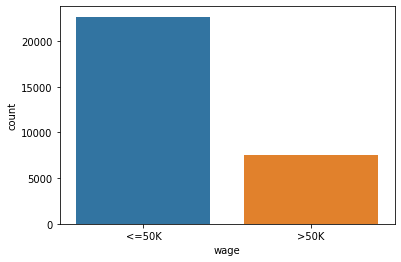

In [ ]:
#Check target variable counts
sns.countplot(data=train_df, x='wage')

The dataset is imbalanced and we need sampling method to improve our model accuracy

**We will now visualize the the relationship between wage and featured variables.**

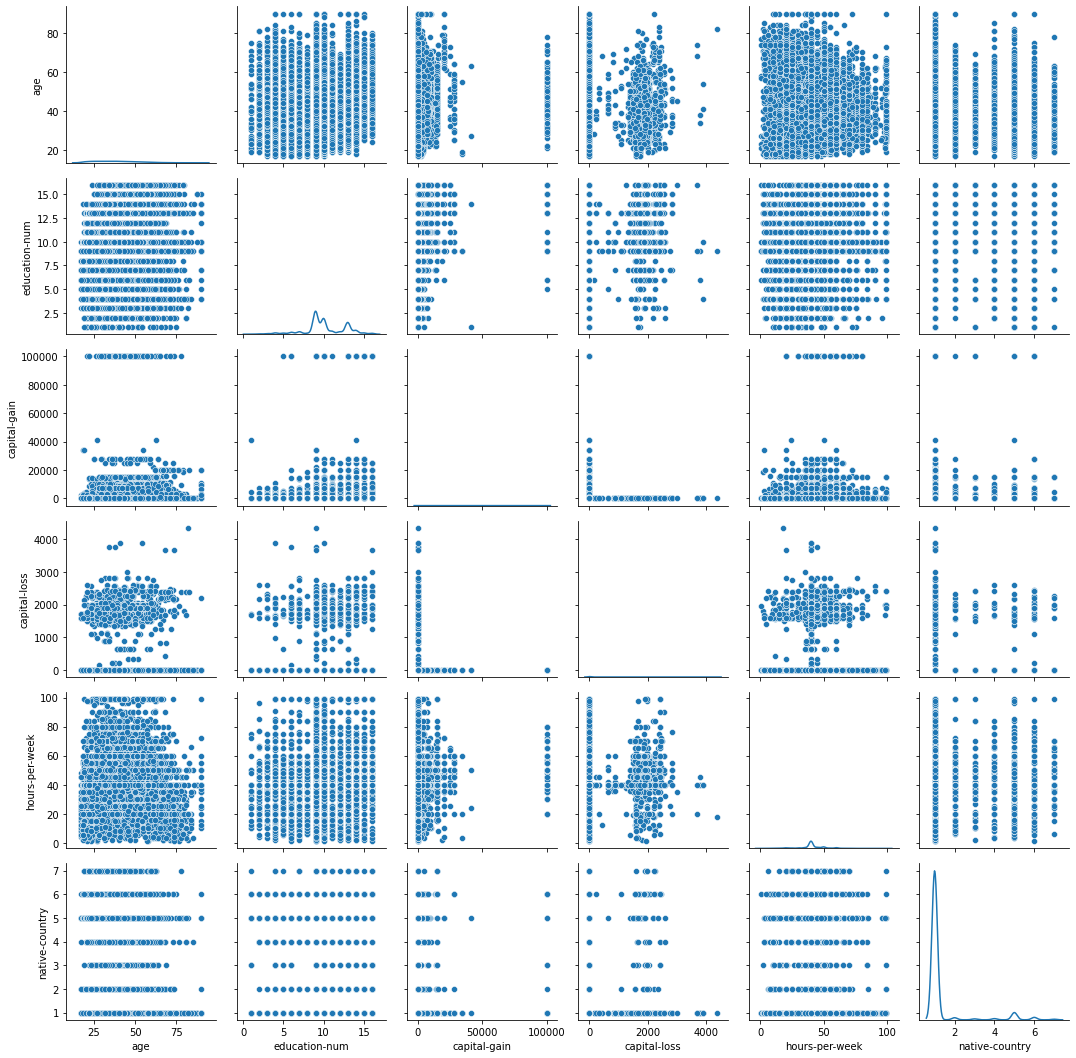

In [ ]:
# Plot the distruction between wage and numeric variables
g = sns.PairGrid(train_df)
g.map_offdiag(sns.scatterplot)
g.map_diag(sns.kdeplot)

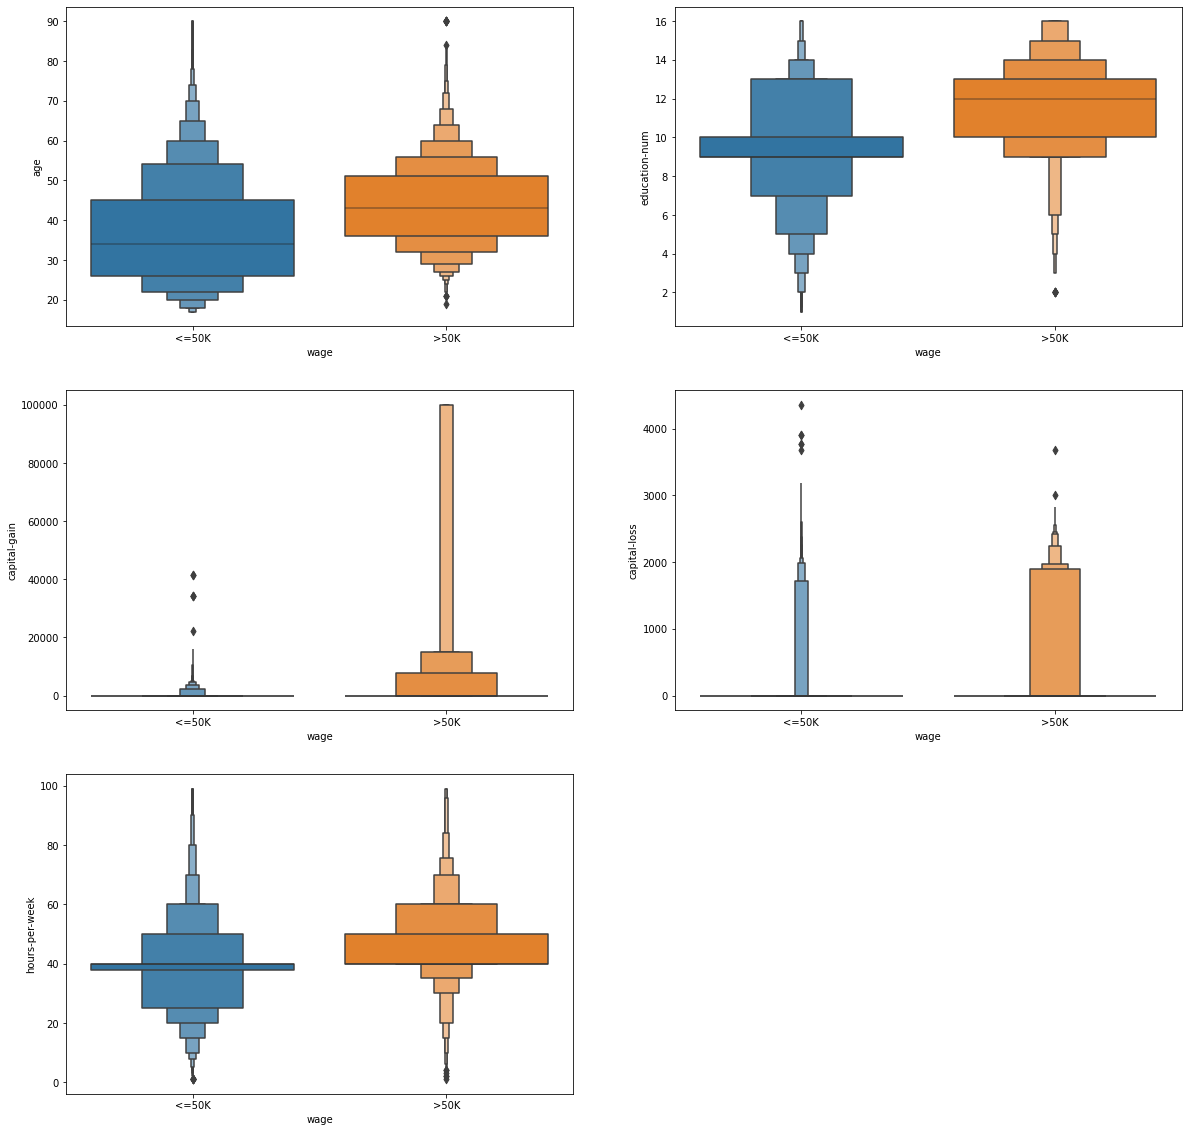

In [ ]:
#Wage and numeric variables

fig = plt.subplots(figsize=(20,20))
for i, col in zip(range(321,326),n_col):
  plt.subplot(i)
  sns.boxenplot(data=train_df, x='wage', y=col)

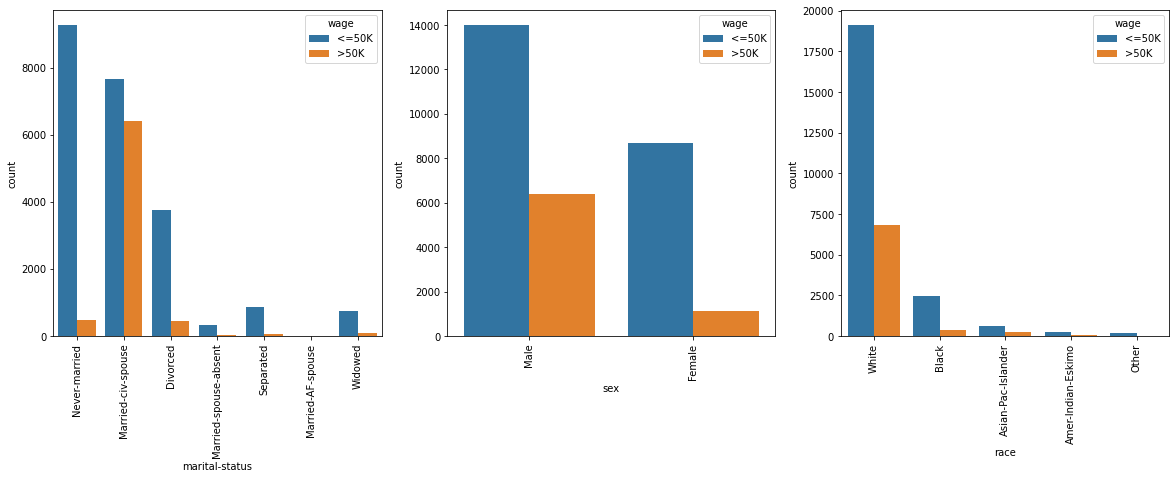

In [ ]:
# Plot the distruction between wage and categorical variables

clist = ['marital-status','sex','race']

fig = plt.subplots(figsize=(20,6))
for i, col in zip(range(131,134), clist):
  plt.subplot(i)
  sns.countplot(data = train_df, x= col , hue='wage')
  plt.xticks(rotation=90)

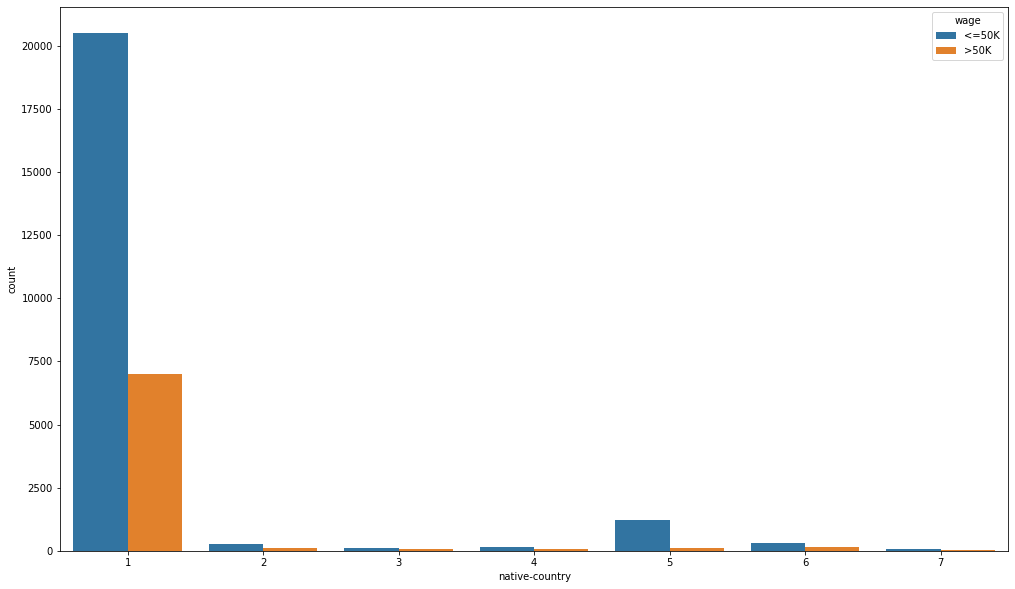

In [ ]:
# Plot the distruction between wage and country

fig = plt.figure(figsize = (17,10))
sns.countplot(data = train_df, x='native-country' ,hue='wage')

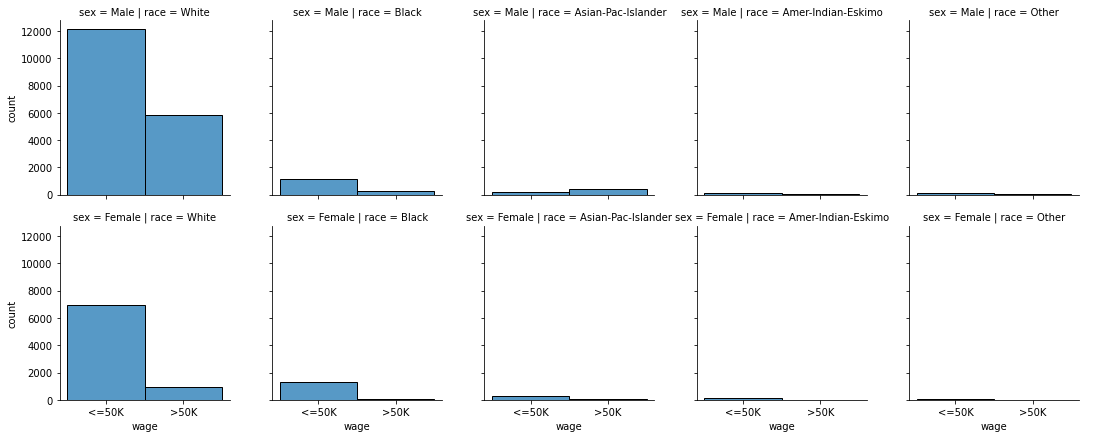

In [ ]:
# Sex and race relationship on wage
f = sns.FacetGrid(train_df, col="race", row="sex")
f.map_dataframe(sns.histplot, x="wage")
f.set_axis_labels('wage',"count")
f.add_legend()

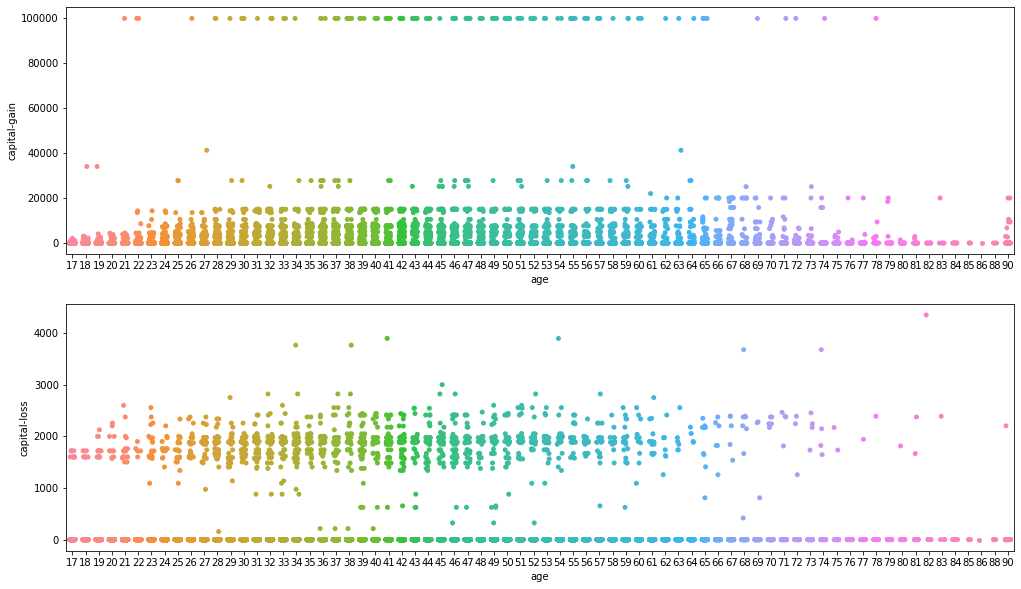

In [ ]:
#Age and Capital gain and loss
fig = plt.figure(figsize = (17,10))

plt.subplot(2,1,1)
sns.stripplot(x='age', y='capital-gain', data = train_df,
         jitter = 0.2);

plt.subplot(2,1,2)
sns.stripplot(x='age', y='capital-loss', data = train_df,
         jitter = 0.2);

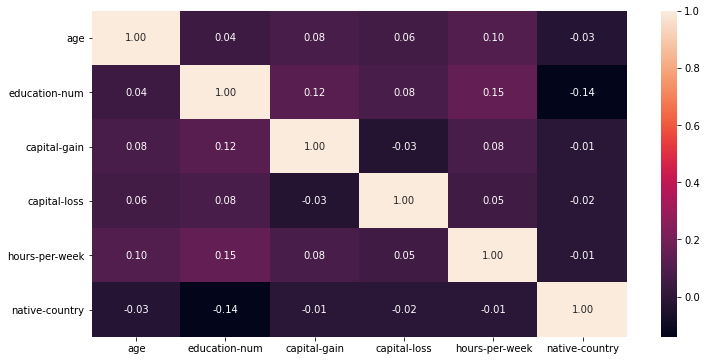

In [ ]:
#find correlation between numeric variables
plt.figure(figsize=(12,6))
sns.heatmap(train_df.corr(),annot=True,fmt='.2f')
plt.show()

No strong correlation between variables

# Feature engineering

**Numeric Features**
First, we will create aggregate `capital-gain` and `capital-loss` into a new column.

In [ ]:
train_df['capital_net'] = train_df['capital-gain']-train_df['capital-loss']
test_df['capital_net'] = test_df['capital-gain']-test_df['capital-loss']
train_df.drop(columns=['capital-gain','capital-loss'],axis=1,inplace=True)
test_df.drop(columns=['capital-gain','capital-loss'],axis=1,inplace=True)

Now we will do PCA to explore the numeric variables relationships and see if we can create more information features

In [ ]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score

# Creating functions to plot the PCA graphs
def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs


                     PC1       PC2       PC3       PC4       PC5
age             0.360516  0.454190 -0.709971  0.334253 -0.218989
education-num   0.578909 -0.313102  0.223155 -0.180893 -0.695925
hours-per-week  0.500571  0.268005 -0.037152 -0.681005  0.460927
native-country -0.316753  0.740470  0.327662 -0.248319 -0.427021
capital_net     0.428940  0.274876  0.580861  0.574563  0.270059


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd5124a5090>,
      dtype=object)

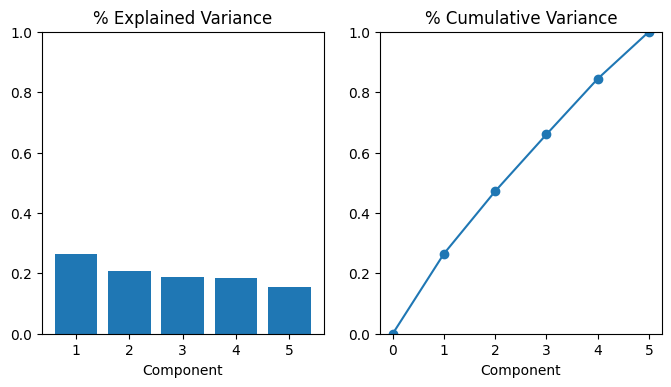

In [ ]:
# Call functions to perform PCA

numerical_cols = train_df.select_dtypes(include=np.number).columns.tolist()
pca, X_pca, loadings = apply_pca(train_df.loc[:,numerical_cols]) 
print(loadings)
plot_variance(pca)

From PCA analysis, all 4 PCs have similar % of explained variance. We cannot reduce dimension from using PCs. And also the PCs are not very intuitive of an actual variable

Now we are going to examine the relationship between `education-num` and `education` to see if they are duplicated

In [ ]:
# Merge two columns and find unique values
edu_s = train_df['education-num'].astype(str) + ' / ' + train_df['education']
edu_s.value_counts().sort_index()

1 / Preschool          45
10 / Some-college    6678
11 / Assoc-voc       1307
12 / Assoc-acdm      1008
13 / Bachelors       5044
14 / Masters         1627
15 / Prof-school      542
16 / Doctorate        375
2 / 1st-4th           151
3 / 5th-6th           288
4 / 7th-8th           557
5 / 9th               455
6 / 10th              820
7 / 11th             1048
8 / 12th              377
9 / HS-grad          9840
dtype: int64

We can see both columns are referring to the same thing. We decide to drop `education` variables.

In [ ]:
train_df.drop(columns='education',axis=1,inplace=True)
test_df.drop(columns='education',axis=1,inplace=True)

# Outlier detection and removal

From above boxplots, we can observe some outliers. We want to detect them and remove them, for capital-gain and capital-loss variables.

In [ ]:
#Using IQR method
def find_outliers(column):
  Q1 = train_df[column].quantile(0.25)
  Q3 = train_df[column].quantile(0.75)
  IQR = Q3 - Q1
  lower_limit = Q1 - 1.5*IQR
  upper_limit = Q3 + 1.5*IQR
  return train_df[(train_df[column]<lower_limit)|(train_df[column]>upper_limit)]

find_outliers('capital_net')

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,wage,capital_net
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,40,1,<=50K,2174
8,31,Private,14,Never-married,Prof-specialty,Not-in-family,White,Female,50,1,>50K,14084
9,42,Private,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,40,1,>50K,5178
23,43,Private,7,Married-civ-spouse,Transport-moving,Husband,White,Male,40,1,<=50K,-2042
32,45,Private,13,Divorced,Exec-managerial,Own-child,White,Male,40,1,<=50K,-1408
...,...,...,...,...,...,...,...,...,...,...,...,...
32515,66,Federal-gov,6,Married-civ-spouse,Craft-repair,Husband,White,Male,40,1,<=50K,3471
32518,57,Local-gov,9,Married-civ-spouse,Craft-repair,Husband,White,Male,40,1,>50K,99999
32538,38,Private,13,Divorced,Prof-specialty,Unmarried,Black,Female,45,1,>50K,15020
32548,65,Self-emp-not-inc,15,Never-married,Prof-specialty,Not-in-family,White,Male,60,1,<=50K,1086


After checking, there are too many rows of `capital-net` that are out of the IQR, therefore we decided just to scale it directly instead.

# Feature Engineering and preparation for machine learning

Since we found out that the dataset is inbalanced, we will use SMOTE method to oversample the data to improve our training

In [ ]:
# Splitting training dataset and testing dataset

X_train = train_df.drop('wage',axis=1)
X_test = test_df.drop('wage',axis=1)

# One Hot encoding target column
y_train = pd.get_dummies(train_df['wage'],drop_first=True)
y_test = pd.get_dummies(test_df['wage'],drop_first=True)


In [ ]:
import time


#Select columns for preprocessing
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = ['age','hours-per-week','capital_net','education-num']


# Bundle preprocessing for numerical and categorical data
preprocessor = make_column_transformer(
    (StandardScaler(), numerical_cols),
    (OneHotEncoder(handle_unknown='ignore'), categorical_cols))


#Select the classifiers we use and train them one by one and record the scores
ML_algos = [
  RandomForestClassifier(),
  SVC(),
  SGDClassifier(),
  KNeighborsClassifier(),
  XGBClassifier(),
  CatBoostClassifier(),
  LGBMClassifier()
  ]

MLA_columns = ['MLA Name', 'MLA Parameters', 'MLA Train Accuracy', 'MLA Test Accuracy','MLA Time']
MLA_df = pd.DataFrame(columns = MLA_columns)


row_index = 0
for algo in ML_algos:
    MLA_name = algo.__class__.__name__
    MLA_df.loc[row_index, 'MLA Name'] = MLA_name
    MLA_df.loc[row_index, 'MLA Parameters'] = str(algo.get_params())

    start = time.time()
    clf = make_pipeline(preprocessor,SMOTE(), algo)
    clf.fit(X_train, y_train.values.ravel())
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    end = time.time()

    MLA_df.loc[row_index, 'MLA Time'] = (end - start)
    MLA_df.loc[row_index, 'MLA Train Accuracy'] = train_score
    MLA_df.loc[row_index, 'MLA Test Accuracy'] = test_score
    
    row_index+=1
    
MLA_df.sort_values(by = ['MLA Test Accuracy'], ascending = False, inplace = True)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Learning rate set to 0.052495
0:	learn: 0.6516660	total: 76.2ms	remaining: 1m 16s
1:	learn: 0.6133375	total: 101ms	remaining: 50.6s
2:	learn: 0.5813467	total: 130ms	remaining: 43s
3:	learn: 0.5542751	total: 154ms	remaining: 38.3s
4:	learn: 0.5307798	total: 179ms	remaining: 35.6s
5:	learn: 0.5110912	total: 208ms	remaining: 34.5s
6:	learn: 0.4964542	total: 234ms	remaining: 33.2s
7:	learn: 0.4816062	total: 260ms	remaining: 32.2s
8:	learn: 0.4693194	total: 286ms	remaining: 31.5s
9:	learn: 0.4570708	total: 312ms	remaining: 30.9s
10:	learn: 0.4478953	total: 337ms	remaining: 30.3s
11:	learn: 0.4405031	total: 360ms	remaining: 29.7s
12:	learn: 0.4335953	total: 384ms	remaining: 29.1s
13:	learn: 0.4285238	total: 408ms	remaining: 28.7s
14:	learn: 0.4229124	total: 438ms	remaining: 28.8s
15:	learn: 0.4167919	total: 463ms	remaining: 28.5s
16:	learn: 0.4118250	total: 490ms	remaining: 28.3s
17:	learn: 0.4082101	total: 514ms	remaining: 28.1s
18:	learn: 0.4046804	total: 537ms	remaining: 27.8s
19:	learn: 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
MLA_df

,MLA Name,MLA Parameters,MLA Train Accuracy,MLA Test Accuracy,MLA Time
5,CatBoostClassifier,{},0.884225,0.861222,37.7838
6,LGBMClassifier,"{'boosting_type': 'gbdt', 'class_weight': None...",0.862874,0.847278,14.2489
0,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.97225,0.834329,52.3703
4,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.821497,0.819256,15.7734
1,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.815231,0.803054,112.336
3,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.86967,0.789973,83.5433
2,SGDClassifier,"{'alpha': 0.0001, 'average': False, 'class_wei...",0.790564,0.788977,12.521


In [ ]:
# #Uncomment the following code to perform GridSearchCV. To save time, we'll just do tuning for XGB Classifier and LGBMClassifier
# tuning_algos = {        
#         'XGBClassifier' : {
#             'model': XGBClassifier(),
#             'params': {
#                 'xgbclassifier__n_estimators': [100, 300, 500,1000],
#                 'xgbclassifier__learning_rate': [0.01, 0.05, 0.1],
#                 'xgbclassifier__max_depth': [2,3,5],
#                 'xgbclassifier__gamma' : [0, 1, 5]
#             }
#         },
#         'LGBMClassifier': {
#             'model': LGBMClassifier(),
#             'params': {
#                 'lgmbclassifier__learning_rate' : [0.01, 0.05,0.1],
#                 'lgbmclassifier__n_estimators': [100,200,500,1000],
#                 'lgbmclassifier__num_leaves': [20,30,50,60]
#             }
#         },

# }


# scores = []
# cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=130)
# for algo_name, config in tuning_algos.items():
#     clf = make_pipeline(preprocessor,SMOTE(), config['model'])
#     gs =  GridSearchCV(clf, config['params'], cv=cv,n_jobs=-1,)
#     gs.fit(X_train,y_train.values.ravel()) 
#     scores.append({
#         'model': algo_name,
#         'best_score': gs.best_score_,
#         'best_params': gs.best_params_
#     })


[{'model': 'XGBClassifier',
  'best_score': 0.8618597712580804,
  'best_params': {'xgbclassifier__gamma': 0,
   'xgbclassifier__learning_rate': 0.1,
   'xgbclassifier__max_depth': 5,
   'xgbclassifier__n_estimators': 1000}}]

[{'model': 'LGBMClassifier',
  'best_score': 0.8584120669650257,
  'best_params': {'lgbmclassifier__learning_rate': 0.05,
   'lgbmclassifier__n_estimators': 1000,
   'lgbmclassifier__num_leaves': 20}}]


Now we will ensemble those 4 algos into our final model using Voting Classifier

In [ ]:
vc = VotingClassifier(estimators=[
       ('xgb', XGBClassifier(gamma=0,
   learning_rate=0.1,
   max_depth=5)), ('cb', CatBoostClassifier()), ('lgb', LGBMClassifier(learning_rate=0.05,n_estimators=1000,num_leaves=20)),('rf',RandomForestClassifier())],
       voting='soft', weights=[1,3,2,2])
clf = make_pipeline(preprocessor,SMOTE(), vc)
clf.fit(X_train, y_train.values.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Learning rate set to 0.052495
0:	learn: 0.6536727	total: 26.9ms	remaining: 26.9s
1:	learn: 0.6142500	total: 51.3ms	remaining: 25.6s
2:	learn: 0.5859607	total: 76.3ms	remaining: 25.4s
3:	learn: 0.5590289	total: 101ms	remaining: 25.2s
4:	learn: 0.5331205	total: 136ms	remaining: 27.1s
5:	learn: 0.5128178	total: 165ms	remaining: 27.3s
6:	learn: 0.4976559	total: 190ms	remaining: 27s
7:	learn: 0.4811266	total: 218ms	remaining: 27.1s
8:	learn: 0.4677855	total: 249ms	remaining: 27.4s
9:	learn: 0.4564077	total: 273ms	remaining: 27.1s
10:	learn: 0.4445626	total: 297ms	remaining: 26.7s
11:	learn: 0.4374495	total: 321ms	remaining: 26.4s
12:	learn: 0.4300641	total: 348ms	remaining: 26.4s
13:	learn: 0.4240068	total: 372ms	remaining: 26.2s
14:	learn: 0.4177318	total: 396ms	remaining: 26s
15:	learn: 0.4126730	total: 425ms	remaining: 26.1s
16:	learn: 0.4083224	total: 450ms	remaining: 26s
17:	learn: 0.4046529	total: 474ms	remaining: 25.9s
18:	learn: 0.3996992	total: 498ms	remaining: 25.7s
19:	learn: 0.3

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('standardscaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['age', 'hours-per-week',
                                                   'capital_net',
                                                   'education-num']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
             

In [ ]:
#Let's see the result
print(f'Test score: {clf.score(X_test,y_test)}')

y_pred = clf.predict(X_test)
print('-'*50)
print(classification_report(y_test, y_pred))

Test score: 0.8547808764940239
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.90      0.90     11360
           1       0.69      0.73      0.71      3700

    accuracy                           0.85     15060
   macro avg       0.80      0.81      0.81     15060
weighted avg       0.86      0.85      0.86     15060



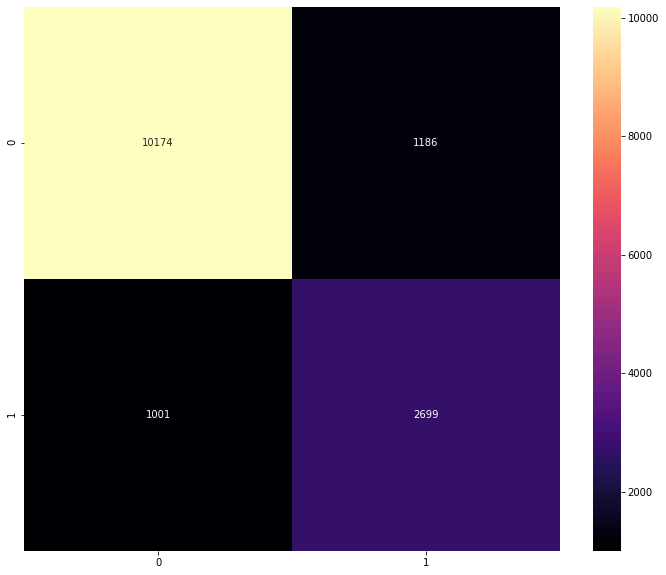

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(data=confusion_matrix(y_test,y_pred),annot=True,fmt='g',cmap="magma")

From the above, we can see our model has pretty good precision and recall

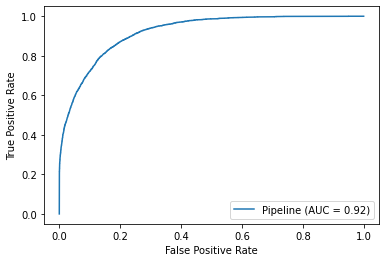

In [ ]:
# Let's check the ROC_curve
plot_roc_curve(clf,X_test, y_test)